In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_date
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Data Quality Check") \
    .getOrCreate()

In [3]:
# Load datasets
users = spark.read.csv('USER.csv', header=True, inferSchema=True)
products = spark.read.csv('PRODUCTS.csv', header=True, inferSchema=True)
transactions = spark.read.csv('TRANSACTION.csv', header=True, inferSchema=True)

In [4]:
# Check schema
users.printSchema()
products.printSchema()
transactions.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CREATED_DATE: timestamp (nullable = true)
 |-- BIRTH_DATE: timestamp (nullable = true)
 |-- STATE: string (nullable = true)
 |-- LANGUAGE: string (nullable = true)
 |-- GENDER: string (nullable = true)

root
 |-- CATEGORY_1: string (nullable = true)
 |-- CATEGORY_2: string (nullable = true)
 |-- CATEGORY_3: string (nullable = true)
 |-- CATEGORY_4: string (nullable = true)
 |-- MANUFACTURER: string (nullable = true)
 |-- BRAND: string (nullable = true)
 |-- BARCODE: long (nullable = true)

root
 |-- RECEIPT_ID: string (nullable = true)
 |-- PURCHASE_DATE: date (nullable = true)
 |-- SCAN_DATE: timestamp (nullable = true)
 |-- STORE_NAME: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- BARCODE: long (nullable = true)
 |-- FINAL_QUANTITY: string (nullable = true)
 |-- FINAL_SALE: string (nullable = true)



In [5]:
# Descriptive statistics
users.describe().show()
products.describe().show()
transactions.describe().show()

+-------+--------------------+-----+--------+--------------------+
|summary|                  ID|STATE|LANGUAGE|              GENDER|
+-------+--------------------+-----+--------+--------------------+
|  count|              100000|95188|   69492|               94108|
|   mean|            Infinity| NULL|    NULL|                NULL|
| stddev|                 NaN| NULL|    NULL|                NULL|
|    min|5351b1efe4b0e3638...|   AK|      en|My gender isn't l...|
|    max|66e1da7387b8a3576...|   WY|  es-419|             unknown|
+-------+--------------------+-----+--------+--------------------+

+-------+----------------+------------------+--------------+--------------------+--------------------+---------+--------------------+
|summary|      CATEGORY_1|        CATEGORY_2|    CATEGORY_3|          CATEGORY_4|        MANUFACTURER|    BRAND|             BARCODE|
+-------+----------------+------------------+--------------+--------------------+--------------------+---------+----------------

In [6]:
# Check missing values
users.select([sum(col(c).isNull().cast("int")).alias(c) for c in users.columns]).show()
products.select([sum(col(c).isNull().cast("int")).alias(c) for c in products.columns]).show()
transactions.select([sum(col(c).isNull().cast("int")).alias(c) for c in transactions.columns]).show()

+---+------------+----------+-----+--------+------+
| ID|CREATED_DATE|BIRTH_DATE|STATE|LANGUAGE|GENDER|
+---+------------+----------+-----+--------+------+
|  0|           0|      3675| 4812|   30508|  5892|
+---+------------+----------+-----+--------+------+

+----------+----------+----------+----------+------------+------+-------+
|CATEGORY_1|CATEGORY_2|CATEGORY_3|CATEGORY_4|MANUFACTURER| BRAND|BARCODE|
+----------+----------+----------+----------+------------+------+-------+
|       111|      1424|     60566|    778093|      226474|226472|   4025|
+----------+----------+----------+----------+------------+------+-------+

+----------+-------------+---------+----------+-------+-------+--------------+----------+
|RECEIPT_ID|PURCHASE_DATE|SCAN_DATE|STORE_NAME|USER_ID|BARCODE|FINAL_QUANTITY|FINAL_SALE|
+----------+-------------+---------+----------+-------+-------+--------------+----------+
|         0|            0|        0|         0|      0|   5762|             0|         0|
+-------

In [7]:
# Check for duplicates
print("Users - Rows after dropping duplicates: ", users.dropDuplicates().count())
print("Products - Rows after dropping duplicates: ", products.dropDuplicates().count())
print("Transactions - Rows after dropping duplicates: ", transactions.dropDuplicates().count())

Users - Rows after dropping duplicates:  100000
Products - Rows after dropping duplicates:  845337
Transactions - Rows after dropping duplicates:  49829


In [8]:
# Convert string to date type for purchase_date and scan_date
transactions = transactions.withColumn("purchase_date", to_date(col("purchase_date"), "yyyy-MM-dd"))
transactions = transactions.withColumn("scan_date", to_date(col("scan_date"), "yyyy-MM-dd"))

In [10]:
# It seems that there are a few inconsistencies in the schema, particularly in the FINAL_QUANTITY and FINAL_SALE fields,
# which are showing up as string types instead of numerical types. This could cause issues when performing analysis or aggregating data.
# Check for non-numeric values in FINAL_QUANTITY
transactions.select("FINAL_QUANTITY").filter(~col("FINAL_QUANTITY").rlike("^\d+$")).show()

# Check for non-numeric values in FINAL_SALE (since it could have decimals, use a regex that allows decimals)
transactions.select("FINAL_SALE").filter(~col("FINAL_SALE").rlike("^\d+(\.\d{1,2})?$")).show()

+--------------+
|FINAL_QUANTITY|
+--------------+
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
|          1.00|
|          zero|
+--------------+
only showing top 20 rows

+----------+
|FINAL_SALE|
+----------+
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
+----------+
only showing top 20 rows



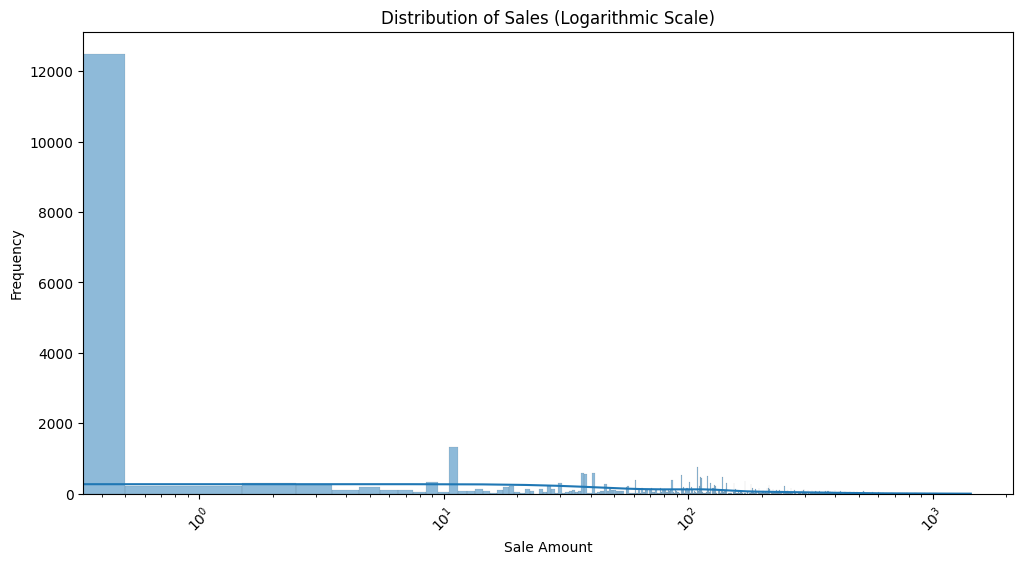

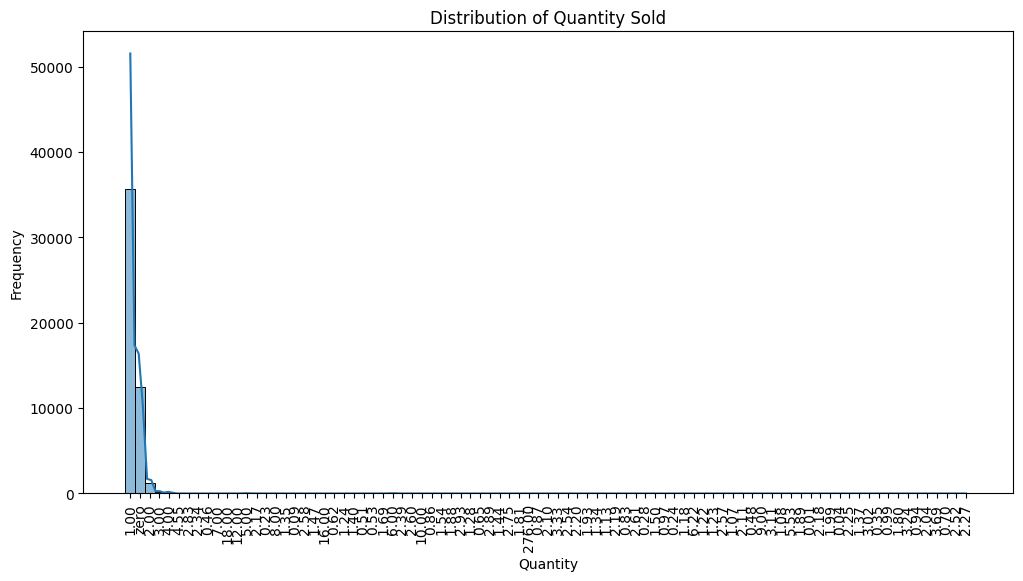

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use log scale on the x-axis for better visibility of skewed sales data
plt.figure(figsize=(12, 6))
sns.histplot(transactions_pd['FINAL_SALE'], bins=50, kde=True)
plt.title('Distribution of Sales (Logarithmic Scale)')
plt.xlabel('Sale Amount')
plt.ylabel('Frequency')
plt.xscale('log')  # Apply log scale to x-axis
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(transactions_pd['FINAL_QUANTITY'], bins=50, kde=True)
plt.title('Distribution of Quantity Sold')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
